In [1]:
%matplotlib inline

In [2]:
def generateSimpleData(delta, alpha, scale, season, init_oh, disc_len, weekMax):

    price = np.append(np.ones( weekMax - disc_len), (1 - delta)*np.ones(disc_len))
    
    slsu = np.zeros(weekMax)
    bst_est = np.zeros(weekMax)
    on_hand = np.zeros(weekMax)
    on_hand[0]=init_oh
    rew = np.zeros(weekMax)
    
    for weekNo in range(weekMax):
        if weekNo:
            on_hand[weekNo] = on_hand[weekNo-1] - slsu[weekNo-1]   
            
        curr_mean =scale*weekMax*season[weekNo]*(price[ weekNo]**(-alpha))
        demand = np.random.poisson(curr_mean)
        slsu[weekNo] = min(demand, on_hand[weekNo])
        rew[weekNo] = slsu[weekNo]*price[weekNo]
        bst_est[weekNo] = curr_mean
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return price,  slsu, on_hand, rew, bst_est

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
weekMax = 12
init_oh = 800

season = np.array([1]*weekMax)
season = season/sum(season)

### Точная оценка Q и V

In [5]:
state_cols = [ 'oh_after', 'days_left']
next_state_cols = [col + '_next' for col in state_cols]

def gen_rl_df(delta, alpha, scale, season, init_oh, disc_len, unit_price =1, weekMax = 12):
    

    dics = np.random.randint(0, weekMax+1)
    price,  slsu, on_hand, rew, best_est = generateSimpleData(delta, alpha, scale, \
                                                    season, init_oh, disc_len = dics, weekMax = weekMax)

    res_ser = rew*unit_price
    days_left = np.arange(weekMax, 0, -1)-1.


    df = pd.concat([pd.Series(price), 
               pd.Series(season),
               pd.Series(on_hand),
               pd.Series(days_left), 
               pd.Series(slsu), 
               pd.Series(res_ser).shift(-1), 
               pd.Series(best_est)], 1)

    
    df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser', 'bst_est']
    df['d_r_sh'] = df.on_hand / df.slsu
    df['oh_after'] = df.on_hand - df.slsu


    df['action'] = (df.price -1. ).fillna(0)
    
    bin_d_left = pd.get_dummies(df.days_left)
    dl_cols = [ 'dl_'+str(col) for col in bin_d_left.columns]
    bin_d_left.columns = dl_cols

    for col, vals in bin_d_left.iteritems():
        df[col] = vals.values
    
    bin_cols = dl_cols
    next_bin_cols = [col + '_next' for col in bin_cols]
    
    df_shifted = df[state_cols+bin_cols].shift(-1)
    df_shifted.columns = next_state_cols + next_bin_cols

    return pd.concat([df[state_cols+bin_cols], df_shifted, df[['action', 'rev_ser', 'slsu', 'bst_est']]], 1), (bin_cols, next_bin_cols)
    


def V(oh_left, reg_sales,disc_sales,delta, days_left  ):
    res_list = [1*min(reg_sales*days_left,oh_left)]
    
    for i in range(days_left):
        reg_price_sales = min(i*reg_sales, oh_left)
        cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
        res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

    return max(res_list)

def Q(oh_left, reg_sales,disc_sales,delta, days_left, action):
    if not days_left:
        return 0
    
    if action >= 0:
        res_list = [1*min(reg_sales*days_left,oh_left)]
        
        for i in range(1, days_left+1):
            reg_price_sales = min(i*reg_sales, oh_left)
            cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
            res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

        return  max(res_list)
    
    return (1- delta)*min(disc_sales*days_left,oh_left)


### Явное обучние нейронной сети

# Keras попытка

In [133]:
samples_list = []
for i in range(1000):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)



In [134]:
dumm_left_df = pd.get_dummies(df.days_left)
dumm_left_df.columns = ['dl_'+ str(col) for col in dumm_left_df.columns]



X = df[['oh_after']].values
X = np.append(df[['oh_after']].values, dumm_left_df.values, 1 )
labels_train = df[[ 'Q_keep','Q_disc']].values

In [102]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad

In [103]:
# define the architecture of the network
model = Sequential()
model.add(Dense(12, input_dim=X.shape[1], init="uniform", activation="relu"))
model.add(Dense(12, activation="relu", kernel_initializer="uniform"))
model.add(Dense(labels_train.shape[1]))
model.compile(RMSprop(), 'MSE')



/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, input_dim=13, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
from tqdm import tqdm 

In [107]:
err_list = []
for i in tqdm(range(75000),mininterval=10 ):
    idx = np.random.randint(X.shape[0], size = 500)
    err = model.train_on_batch(X[idx], labels_train[idx])
    err_list.append(err)
    if i %500 ==0 :
        print(err)








  0%|          | 0/75000 [00:00<?, ?it/s]

30.73823
16.934153
26.274641
17.67349
19.778008
15.062223
20.053003
21.039879
19.577301
15.352924
10.207244
11.167543
8.556785









  8%|▊         | 6170/75000 [00:10<01:51, 616.93it/s]

17.952225
17.689949
20.92881
21.299816
21.015717
27.73089
27.270372
24.92502
17.445442
27.020582
10.770084
19.971386









 16%|█▋        | 12347/75000 [00:20<01:41, 617.30it/s]

34.47642
30.241037
20.580652
15.35715
18.941458


KeyboardInterrupt: 

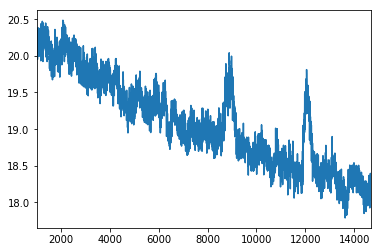








 16%|█▋        | 12347/75000 [00:35<02:58, 351.20it/s]

In [108]:
pd.Series(err_list).rolling(200).mean().iloc[1000:].plot()

In [25]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 100/100 [00:00<00:00, 166.12it/s]


In [65]:
#pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred', 'q_disc_pred'])
pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_disc_pred'])

df['q_disc_pred'] = pred_df['q_disc_pred']
#df['q_disc_pred'] = pred_df['q_disc_pred']

In [67]:
#df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep', 'Q_disc', 'q_keep_pred', 'q_disc_pred'] ]
df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_disc',  'q_disc_pred'] ]

,days_left,oh_after,action,rev_ser,Q_disc,q_disc_pred
0,11,762.0,0.00,34.00,495.3000,495.094055
1,10,728.0,0.00,46.00,473.2000,473.040283
2,9,682.0,0.00,28.00,443.3000,443.111786
3,8,654.0,0.00,38.00,425.1000,424.995361
4,7,616.0,0.00,42.00,400.4000,400.316681
5,6,574.0,0.00,30.00,369.2130,366.863159
6,5,544.0,0.00,44.00,307.6775,305.256409
7,4,500.0,0.00,48.00,246.1420,243.712891
8,3,452.0,0.00,45.00,184.6065,182.187469
9,2,407.0,0.00,49.00,123.0710,120.648468


### Честный Q-learning на Keras с использованием нейронных сетей

In [207]:
samples_list = []
for i in (range(1000)):
    tmp_df, new_state_cols = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples.fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

In [84]:

state_cols = ['oh_after','days_left']
next_state_cols = [col + '_next' for col in state_cols]


used_cols = ['days_left', 'oh_after', 'action', 'rev_ser', 'days_left_next', 'oh_after_next']
col_n2no =  {name:i for i, name in  enumerate(used_cols)}

X = df[used_cols].values


state_cols_nos = [col_n2no[name] for name in state_cols]
next_state_cols_nos = [col_n2no[name] for name in next_state_cols]

state_cols_nos, next_state_cols_nos


([1, 0], [5, 4])

In [85]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad

# define the architecture of the network
model_z = Sequential()
model_z.add(Dense(4, input_dim=2, init="uniform", activation="relu"))
model_z.add(Dense(4, activation="relu", kernel_initializer="uniform"))
model_z.add(Dense(1))
model_z.compile(RMSprop(), 'MSE')

model_m35 = Sequential()
model_m35.add(Dense(4, input_dim=2, init="uniform", activation="relu"))
model_m35.add(Dense(4, activation="relu", kernel_initializer="uniform"))
model_m35.add(Dense(1))
model_m35.compile(RMSprop(), 'MSE')

/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, input_dim=2, activation="relu", kernel_initializer="uniform")`
  
/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, input_dim=2, activation="relu", kernel_initializer="uniform")`
  


In [82]:
err_list = []
q_0_hist = []
for i in tqdm(range(150000), mininterval=10):
    idx = np.random.randint(df.shape[0], size = 500)
    X_curr = X[idx]

    next_pred_z   = model_z.predict(X_curr[:, next_state_cols_nos])
    next_pred_m35 = model_m35.predict(X_curr[:, next_state_cols_nos])
    
    last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

    next_pred_z[last_day_ind] = 0.
    next_pred_m35[last_day_ind] = 0.

    m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
    z_action_ind   = np.where(X_curr[:, col_n2no['action']] ==0.)

    next_pred_m35[m35_action_ind, 0] += X_curr[m35_action_ind, col_n2no['rev_ser']]
    next_pred_z[z_action_ind, 0]     += X_curr[z_action_ind, col_n2no['rev_ser']]

    err_z   = model_z.train_on_batch(X_curr[:,state_cols_nos], next_pred_z)
    err_m35 = model_m35.train_on_batch(X_curr[:,state_cols_nos], next_pred_m35)
    err_list.append((err_z, err_m35))
    if not i%500:
        mean_q_0   = next_pred_z[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        mean_q_m35 = next_pred_m35[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        q_0_hist.append((mean_q_0, mean_q_m35))
        print('err_z, err_m35',(err_z, err_m35))
        print('mean_q_0, mean_q_m35',(mean_q_0, mean_q_m35))





  0%|          | 0/150000 [00:00<?, ?it/s]


  6%|▌         | 8885/150000 [02:18<36:44, 64.00it/s]

err_z, err_m35 (913.9682, 1361.9323)
mean_q_0, mean_q_m35 (38.755276, 4.9402742)
err_z, err_m35 (1501.252, 758.95947)
mean_q_0, mean_q_m35 (344.19092, 177.93863)






  0%|          | 565/150000 [00:10<44:05, 56.49it/s]

err_z, err_m35 (1349.7198, 706.74469)
mean_q_0, mean_q_m35 (352.79218, 178.72546)






  1%|          | 1279/150000 [00:20<38:46, 63.92it/s]

err_z, err_m35 (1287.1257, 722.15436)
mean_q_0, mean_q_m35 (349.38293, 183.41484)






  1%|▏         | 1993/150000 [00:30<37:10, 66.36it/s]

err_z, err_m35 (1427.4165, 788.03967)
mean_q_0, mean_q_m35 (348.31229, 182.34192)
err_z, err_m35 (1318.854, 770.24585)
mean_q_0, mean_q_m35 (354.06412, 181.54936)






  2%|▏         | 2706/150000 [00:40<36:20, 67.55it/s]

err_z, err_m35 (1020.8829, 793.8103)
mean_q_0, mean_q_m35 (318.7323, 196.22517)






  2%|▏         | 3419/150000 [00:50<35:46, 68.29it/s]

err_z, err_m35 (988.16144, 1033.1372)
mean_q_0, mean_q_m35 (337.77164, 191.03337)
err_z, err_m35 (929.56372, 1510.3726)
mean_q_0, mean_q_m35 (342.32864, 173.58769)






  3%|▎         | 4132/150000 [01:00<35:21, 68.76it/s]

err_z, err_m35 (851.2359, 2005.47)
mean_q_0, mean_q_m35 (329.28781, 194.88246)






  3%|▎         | 4846/150000 [01:10<34:59, 69.12it/s]

err_z, err_m35 (851.98438, 2260.45)
mean_q_0, mean_q_m35 (323.86194, 199.9216)
err_z, err_m35 (723.12427, 2534.5144)
mean_q_0, mean_q_m35 (325.06387, 197.68832)






  4%|▎         | 5560/150000 [01:20<34:41, 69.40it/s]

err_z, err_m35 (832.87018, 2309.9326)
mean_q_0, mean_q_m35 (300.10406, 216.57324)






  4%|▍         | 6274/150000 [01:30<34:24, 69.62it/s]

err_z, err_m35 (732.39459, 2209.3567)
mean_q_0, mean_q_m35 (278.74097, 203.48166)






  5%|▍         | 6988/150000 [01:40<34:09, 69.78it/s]

err_z, err_m35 (995.18024, 2688.6294)
mean_q_0, mean_q_m35 (288.02463, 228.80347)
err_z, err_m35 (672.8205, 2528.0281)
mean_q_0, mean_q_m35 (242.89366, 216.08742)






  5%|▌         | 7703/150000 [01:50<33:54, 69.93it/s]

err_z, err_m35 (740.68085, 2309.8936)
mean_q_0, mean_q_m35 (275.6875, 189.63171)






  6%|▌         | 8418/150000 [02:00<33:41, 70.04it/s]

err_z, err_m35 (1039.8668, 2156.937)
mean_q_0, mean_q_m35 (265.60461, 189.86513)
err_z, err_m35 (754.14026, 2269.447)
mean_q_0, mean_q_m35 (241.18843, 196.17188)






  6%|▌         | 9132/150000 [02:10<33:28, 70.14it/s]

err_z, err_m35 (774.73242, 1970.4709)
mean_q_0, mean_q_m35 (251.58467, 191.37846)






  7%|▋         | 9847/150000 [02:20<33:15, 70.23it/s]

err_z, err_m35 (942.02484, 1966.6683)
mean_q_0, mean_q_m35 (251.32069, 176.10759)
err_z, err_m35 (1017.8057, 1683.366)
mean_q_0, mean_q_m35 (255.1324, 206.82837)






  7%|▋         | 10562/150000 [02:30<33:03, 70.30it/s]

err_z, err_m35 (1029.1212, 1883.1724)
mean_q_0, mean_q_m35 (230.63921, 206.87622)






  8%|▊         | 11276/150000 [02:40<32:51, 70.37it/s]

err_z, err_m35 (973.56219, 1758.2336)
mean_q_0, mean_q_m35 (254.343, 167.77393)






  8%|▊         | 11991/150000 [02:50<32:39, 70.43it/s]

err_z, err_m35 (821.95801, 1685.7732)
mean_q_0, mean_q_m35 (228.77539, 182.66086)


KeyboardInterrupt: 





  8%|▊         | 11991/150000 [03:01<34:46, 66.14it/s]

In [ ]:
err_list = []
q_0_hist = []
for i in tqdm(range(150000), mininterval=10):
    idx = np.random.randint(df.shape[0], size = 500)
    X_curr = X[idx]

    next_pred_z   = model_z.predict(X_curr[:, next_state_cols_nos])
    next_pred_m35 = model_m35.predict(X_curr[:, next_state_cols_nos])
    
    last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

    next_pred_z[last_day_ind] = 0.
    next_pred_m35[last_day_ind] = 0.
    
    next_pred_z[:, 0] += X_curr[:, col_n2no['rev_ser']]
    next_pred_m35[:, 0] += X_curr[:, col_n2no['rev_ser']]

    m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
    z_action_ind   = np.where(X_curr[:, col_n2no['action']] ==0.)

    #next_pred_m35[m35_action_ind, 0] += X_curr[m35_action_ind, col_n2no['rev_ser']]
    #next_pred_z[z_action_ind, 0]     += X_curr[z_action_ind, col_n2no['rev_ser']]
    

    err_z   = model_z.train_on_batch(X_curr[z_action_ind][:,state_cols_nos], next_pred_z[z_action_ind])
    err_m35 = model_m35.train_on_batch(X_curr[m35_action_ind][:,state_cols_nos], next_pred_m35[m35_action_ind])
    err_list.append((err_z, err_m35))
    if not i%500:
        mean_q_0   = next_pred_z[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        mean_q_m35 = next_pred_m35[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        q_0_hist.append((mean_q_0, mean_q_m35))
        print('err_z, err_m35',(err_z, err_m35))
        print('mean_q_0, mean_q_m35',(mean_q_0, mean_q_m35))






  0%|          | 0/150000 [00:00<?, ?it/s]

err_z, err_m35 (2049.0396, 2295.7156)
mean_q_0, mean_q_m35 (43.666668, 43.010418)
err_z, err_m35 (1990.5438, 2358.9795)
mean_q_0, mean_q_m35 (45.122753, 45.122589)







  0%|          | 573/150000 [00:10<43:29, 57.26it/s]

err_z, err_m35 (1836.9249, 2358.0977)
mean_q_0, mean_q_m35 (43.704132, 43.703583)







  1%|          | 1269/150000 [00:20<39:05, 63.42it/s]

err_z, err_m35 (2026.5778, 2578.1077)
mean_q_0, mean_q_m35 (43.934864, 43.933887)







  1%|▏         | 1965/150000 [00:30<37:41, 65.47it/s]

err_z, err_m35 (1870.5447, 2687.1382)
mean_q_0, mean_q_m35 (43.60622, 43.604465)
err_z, err_m35 (1873.955, 2683.6023)
mean_q_0, mean_q_m35 (46.38966, 46.387558)







  2%|▏         | 2661/150000 [00:40<36:56, 66.48it/s]

err_z, err_m35 (1920.161, 2685.9146)
mean_q_0, mean_q_m35 (45.078163, 45.075508)







  2%|▏         | 3357/150000 [00:50<36:25, 67.10it/s]

err_z, err_m35 (1936.2679, 2422.3496)
mean_q_0, mean_q_m35 (47.417393, 47.414135)
err_z, err_m35 (2036.5154, 2780.52)
mean_q_0, mean_q_m35 (48.84259, 48.838856)







  3%|▎         | 4053/150000 [01:00<36:01, 67.51it/s]

err_z, err_m35 (1905.6212, 2429.8867)
mean_q_0, mean_q_m35 (46.689743, 46.685501)







  3%|▎         | 4750/150000 [01:10<35:41, 67.82it/s]

err_z, err_m35 (1916.9865, 2601.4604)
mean_q_0, mean_q_m35 (48.493683, 48.489002)







  4%|▎         | 5447/150000 [01:20<35:24, 68.04it/s]

err_z, err_m35 (1879.1572, 2607.4651)
mean_q_0, mean_q_m35 (50.038269, 50.033062)
err_z, err_m35 (1994.5421, 2427.3977)
mean_q_0, mean_q_m35 (49.914185, 49.908272)







  4%|▍         | 6143/150000 [01:30<35:09, 68.20it/s]

err_z, err_m35 (1877.0129, 2717.376)
mean_q_0, mean_q_m35 (48.864346, 48.858074)







  5%|▍         | 6839/150000 [01:40<34:54, 68.34it/s]

err_z, err_m35 (1939.2969, 2623.7339)
mean_q_0, mean_q_m35 (51.648804, 51.64193)
err_z, err_m35 (1751.8345, 2187.762)
mean_q_0, mean_q_m35 (49.227261, 49.219883)







  5%|▌         | 7535/150000 [01:50<34:41, 68.45it/s]

err_z, err_m35 (1910.8275, 2599.7378)
mean_q_0, mean_q_m35 (53.702209, 53.694286)







  5%|▌         | 8232/150000 [02:00<34:28, 68.55it/s]

err_z, err_m35 (1831.9503, 2573.6238)
mean_q_0, mean_q_m35 (49.213665, 49.204941)







  6%|▌         | 8929/150000 [02:10<34:15, 68.63it/s]

err_z, err_m35 (1863.8395, 2606.3704)
mean_q_0, mean_q_m35 (52.33696, 52.327881)
err_z, err_m35 (1898.7318, 2586.8682)
mean_q_0, mean_q_m35 (51.436901, 51.42717)







  6%|▋         | 9626/150000 [02:20<34:03, 68.70it/s]

err_z, err_m35 (1938.4459, 2664.2163)
mean_q_0, mean_q_m35 (52.934536, 52.923668)







  7%|▋         | 10323/150000 [02:30<33:51, 68.77it/s]

err_z, err_m35 (1898.9347, 2479.6147)
mean_q_0, mean_q_m35 (53.40411, 53.3927)
err_z, err_m35 (1867.4419, 2549.3269)
mean_q_0, mean_q_m35 (54.635555, 54.623837)







  7%|▋         | 11020/150000 [02:40<33:39, 68.81it/s]

err_z, err_m35 (2017.2716, 2490.4846)
mean_q_0, mean_q_m35 (56.997406, 56.984871)







  8%|▊         | 11716/150000 [02:50<33:28, 68.86it/s]

err_z, err_m35 (2059.2837, 2294.2539)
mean_q_0, mean_q_m35 (56.202045, 56.188438)







  8%|▊         | 12412/150000 [03:00<33:17, 68.89it/s]

err_z, err_m35 (1877.5852, 2415.343)
mean_q_0, mean_q_m35 (54.415325, 54.401302)
err_z, err_m35 (1968.3677, 2570.3372)
mean_q_0, mean_q_m35 (56.324177, 56.309368)







  9%|▊         | 13108/150000 [03:10<33:06, 68.93it/s]

err_z, err_m35 (1872.7478, 2410.7625)
mean_q_0, mean_q_m35 (56.671341, 56.65575)







  9%|▉         | 13806/150000 [03:20<32:54, 68.97it/s]

err_z, err_m35 (1778.1003, 2505.1577)
mean_q_0, mean_q_m35 (56.375656, 56.359375)







 10%|▉         | 14504/150000 [03:30<32:43, 69.00it/s]

err_z, err_m35 (1901.4301, 2530.0171)
mean_q_0, mean_q_m35 (59.004719, 58.987713)
err_z, err_m35 (1867.4967, 2409.6711)
mean_q_0, mean_q_m35 (57.944603, 57.926914)







 10%|█         | 15203/150000 [03:40<32:32, 69.04it/s]

err_z, err_m35 (1927.2922, 2484.2466)
mean_q_0, mean_q_m35 (58.274082, 58.255405)







 11%|█         | 15902/150000 [03:50<32:21, 69.06it/s]

err_z, err_m35 (1931.1312, 2468.4663)
mean_q_0, mean_q_m35 (58.025379, 58.005821)
err_z, err_m35 (1865.4603, 2447.7593)
mean_q_0, mean_q_m35 (56.178677, 56.158394)







 11%|█         | 16598/150000 [04:00<32:11, 69.08it/s]

err_z, err_m35 (1935.0587, 2425.365)
mean_q_0, mean_q_m35 (60.394581, 60.373562)







 12%|█▏        | 17296/150000 [04:10<32:00, 69.10it/s]

err_z, err_m35 (1843.8907, 2566.2627)
mean_q_0, mean_q_m35 (56.969791, 56.948032)







 12%|█▏        | 17995/150000 [04:20<31:49, 69.13it/s]

err_z, err_m35 (1790.7451, 2361.8308)
mean_q_0, mean_q_m35 (60.056358, 60.033588)
err_z, err_m35 (2002.3412, 2550.1426)
mean_q_0, mean_q_m35 (61.007507, 60.983845)







 12%|█▏        | 18694/150000 [04:30<31:38, 69.15it/s]

err_z, err_m35 (1904.3689, 2598.9299)
mean_q_0, mean_q_m35 (63.529476, 63.504803)







 13%|█▎        | 19392/150000 [04:40<31:28, 69.17it/s]

err_z, err_m35 (1873.9403, 2571.2744)
mean_q_0, mean_q_m35 (63.1273, 63.101608)
err_z, err_m35 (1872.894, 2490.5247)
mean_q_0, mean_q_m35 (62.28812, 62.261299)







 13%|█▎        | 20089/150000 [04:50<31:17, 69.19it/s]

err_z, err_m35 (1863.8601, 2483.1741)
mean_q_0, mean_q_m35 (61.047405, 61.019718)







 14%|█▍        | 20788/150000 [05:00<31:06, 69.21it/s]

err_z, err_m35 (1896.976, 2487.9954)
mean_q_0, mean_q_m35 (64.797791, 64.768913)







 14%|█▍        | 21487/150000 [05:10<30:56, 69.22it/s]

err_z, err_m35 (1913.9308, 2403.6248)
mean_q_0, mean_q_m35 (60.695347, 60.665424)
err_z, err_m35 (1809.7278, 2461.5569)
mean_q_0, mean_q_m35 (62.747597, 62.717068)







 15%|█▍        | 22186/150000 [05:20<30:45, 69.24it/s]

err_z, err_m35 (1968.5967, 2688.8901)
mean_q_0, mean_q_m35 (65.991714, 65.959869)







 15%|█▌        | 22884/150000 [05:30<30:35, 69.25it/s]

err_z, err_m35 (1804.6642, 2452.8499)
mean_q_0, mean_q_m35 (66.190338, 66.157372)
err_z, err_m35 (1782.2032, 2370.1228)
mean_q_0, mean_q_m35 (64.550331, 64.516243)







 16%|█▌        | 23581/150000 [05:40<30:25, 69.27it/s]

err_z, err_m35 (1778.8425, 2633.238)
mean_q_0, mean_q_m35 (66.7444, 66.709511)







 16%|█▌        | 24279/150000 [05:50<30:14, 69.28it/s]

err_z, err_m35 (1894.0403, 2467.0911)
mean_q_0, mean_q_m35 (68.402573, 68.366486)







 17%|█▋        | 24977/150000 [06:00<30:04, 69.29it/s]

err_z, err_m35 (1846.6542, 2440.4922)
mean_q_0, mean_q_m35 (69.6651, 69.627762)
err_z, err_m35 (1878.5951, 2480.1646)
mean_q_0, mean_q_m35 (67.868813, 67.830185)







 17%|█▋        | 25674/150000 [06:10<29:54, 69.30it/s]

err_z, err_m35 (1912.5449, 2482.6179)
mean_q_0, mean_q_m35 (69.998886, 69.958832)







 18%|█▊        | 26371/150000 [06:20<29:43, 69.31it/s]

err_z, err_m35 (1872.4166, 2493.124)
mean_q_0, mean_q_m35 (71.150566, 71.109367)
err_z, err_m35 (1807.1216, 2612.7349)
mean_q_0, mean_q_m35 (71.287636, 71.24501)







 18%|█▊        | 27068/150000 [06:30<29:33, 69.31it/s]

err_z, err_m35 (1836.749, 2534.4302)
mean_q_0, mean_q_m35 (69.615082, 69.571342)







 19%|█▊        | 27766/150000 [06:40<29:23, 69.32it/s]

err_z, err_m35 (1796.5227, 2750.8936)
mean_q_0, mean_q_m35 (73.964706, 73.919403)







 19%|█▉        | 28464/150000 [06:50<29:12, 69.33it/s]

err_z, err_m35 (1835.6606, 2595.3066)
mean_q_0, mean_q_m35 (71.24231, 71.195618)
err_z, err_m35 (1838.7139, 2529.6624)
mean_q_0, mean_q_m35 (72.09053, 72.042786)







 19%|█▉        | 29160/150000 [07:00<29:02, 69.33it/s]

err_z, err_m35 (1873.3976, 2600.2126)
mean_q_0, mean_q_m35 (73.594704, 73.545692)







 20%|█▉        | 29855/150000 [07:10<28:52, 69.33it/s]

err_z, err_m35 (1910.376, 2615.3638)
mean_q_0, mean_q_m35 (75.32579, 75.27478)
err_z, err_m35 (1828.5665, 2308.8892)
mean_q_0, mean_q_m35 (72.735176, 72.68293)







 20%|██        | 30552/150000 [07:20<28:42, 69.34it/s]

err_z, err_m35 (1877.3798, 2690.8691)
mean_q_0, mean_q_m35 (72.479576, 72.425949)







 21%|██        | 31249/150000 [07:30<28:32, 69.34it/s]

err_z, err_m35 (1970.6326, 2562.019)
mean_q_0, mean_q_m35 (74.776733, 74.721375)







 21%|██▏       | 31947/150000 [07:40<28:22, 69.35it/s]

err_z, err_m35 (1825.0164, 2515.9397)
mean_q_0, mean_q_m35 (73.431366, 73.374344)
err_z, err_m35 (1801.3197, 2632.0598)
mean_q_0, mean_q_m35 (75.396027, 75.337822)







 22%|██▏       | 32645/150000 [07:50<28:11, 69.36it/s]

err_z, err_m35 (1748.7018, 2719.385)
mean_q_0, mean_q_m35 (75.284042, 75.224045)







 22%|██▏       | 33343/150000 [08:00<28:01, 69.37it/s]

err_z, err_m35 (1869.5717, 2468.77)
mean_q_0, mean_q_m35 (76.294487, 76.232689)
err_z, err_m35 (1877.8641, 2545.4033)
mean_q_0, mean_q_m35 (74.100845, 74.03727)







 23%|██▎       | 34041/150000 [08:10<27:51, 69.38it/s]

err_z, err_m35 (1846.0201, 2689.8325)
mean_q_0, mean_q_m35 (77.572449, 77.507324)







 23%|██▎       | 34740/150000 [08:20<27:41, 69.38it/s]

err_z, err_m35 (1823.6837, 2742.4358)
mean_q_0, mean_q_m35 (78.59626, 78.529449)







 24%|██▎       | 35439/150000 [08:30<27:30, 69.39it/s]

err_z, err_m35 (1937.1935, 2634.4492)
mean_q_0, mean_q_m35 (77.529068, 77.459999)
err_z, err_m35 (1920.874, 2567.8489)
mean_q_0, mean_q_m35 (78.034935, 77.963699)







 24%|██▍       | 36136/150000 [08:40<27:20, 69.39it/s]

err_z, err_m35 (1879.5229, 2647.4534)
mean_q_0, mean_q_m35 (79.512123, 79.43914)







 25%|██▍       | 36834/150000 [08:50<27:10, 69.40it/s]

err_z, err_m35 (1925.6907, 2590.2917)
mean_q_0, mean_q_m35 (79.163795, 79.089417)
err_z, err_m35 (1854.8253, 2678.2236)
mean_q_0, mean_q_m35 (79.465164, 79.388405)







 25%|██▌       | 37532/150000 [09:00<27:00, 69.40it/s]

err_z, err_m35 (1788.3335, 2677.4988)
mean_q_0, mean_q_m35 (81.378426, 81.299622)







 25%|██▌       | 38228/150000 [09:10<26:50, 69.41it/s]

err_z, err_m35 (1822.9277, 2732.252)
mean_q_0, mean_q_m35 (80.618195, 80.537163)







 26%|██▌       | 38927/150000 [09:20<26:40, 69.42it/s]

err_z, err_m35 (1876.7566, 2686.231)
mean_q_0, mean_q_m35 (83.111916, 83.028931)
err_z, err_m35 (1872.6747, 2779.3225)
mean_q_0, mean_q_m35 (85.777054, 85.69239)







 26%|██▋       | 39626/150000 [09:30<26:29, 69.42it/s]

err_z, err_m35 (2003.2981, 2669.5325)
mean_q_0, mean_q_m35 (85.005203, 84.918167)







 27%|██▋       | 40323/150000 [09:40<26:19, 69.42it/s]

err_z, err_m35 (1854.3567, 2819.9631)
mean_q_0, mean_q_m35 (81.360573, 81.271355)
err_z, err_m35 (1849.8131, 2803.1226)
mean_q_0, mean_q_m35 (82.997574, 82.905754)







 27%|██▋       | 41020/150000 [09:50<26:09, 69.43it/s]

err_z, err_m35 (1910.7391, 2811.7478)
mean_q_0, mean_q_m35 (85.705788, 85.611938)







 28%|██▊       | 41717/150000 [10:00<25:59, 69.43it/s]

err_z, err_m35 (1882.4313, 2743.7703)
mean_q_0, mean_q_m35 (84.990601, 84.894745)







 28%|██▊       | 42413/150000 [10:10<25:49, 69.43it/s]

err_z, err_m35 (1814.499, 2744.1147)
mean_q_0, mean_q_m35 (85.011589, 84.913406)
err_z, err_m35 (1924.0566, 2677.6052)
mean_q_0, mean_q_m35 (85.081406, 84.98069)







 29%|██▊       | 43111/150000 [10:20<25:39, 69.44it/s]

err_z, err_m35 (1856.5404, 2684.3154)
mean_q_0, mean_q_m35 (84.655067, 84.552063)







 29%|██▉       | 43809/150000 [10:30<25:29, 69.44it/s]

err_z, err_m35 (1890.8015, 2858.0676)
mean_q_0, mean_q_m35 (85.919762, 85.814384)







 30%|██▉       | 44507/150000 [10:40<25:19, 69.44it/s]

err_z, err_m35 (1843.0133, 2839.175)
mean_q_0, mean_q_m35 (89.92704, 89.819008)
err_z, err_m35 (1999.1029, 2797.042)
mean_q_0, mean_q_m35 (86.167938, 86.057365)







 30%|███       | 45205/150000 [10:50<25:08, 69.45it/s]

err_z, err_m35 (1808.384, 2777.9661)
mean_q_0, mean_q_m35 (86.470459, 86.356812)







 31%|███       | 45903/150000 [11:00<24:58, 69.45it/s]

err_z, err_m35 (1865.2903, 2853.8611)
mean_q_0, mean_q_m35 (93.976456, 93.860825)
err_z, err_m35 (1912.6205, 2737.5483)
mean_q_0, mean_q_m35 (90.087151, 89.968437)







 31%|███       | 46601/150000 [11:10<24:48, 69.46it/s]

err_z, err_m35 (1855.5625, 2869.429)
mean_q_0, mean_q_m35 (89.237183, 89.115967)







 32%|███▏      | 47298/150000 [11:20<24:38, 69.46it/s]

err_z, err_m35 (1873.2264, 2805.4534)
mean_q_0, mean_q_m35 (88.559357, 88.43486)







 32%|███▏      | 47995/150000 [11:30<24:28, 69.46it/s]

err_z, err_m35 (1885.0129, 2825.1516)
mean_q_0, mean_q_m35 (90.740677, 90.613167)
err_z, err_m35 (1982.1996, 2771.7776)
mean_q_0, mean_q_m35 (90.132576, 90.002144)







 32%|███▏      | 48693/150000 [11:40<24:18, 69.47it/s]

err_z, err_m35 (1791.0674, 2724.6304)
mean_q_0, mean_q_m35 (91.460136, 91.326782)







 33%|███▎      | 49391/150000 [11:50<24:08, 69.47it/s]

err_z, err_m35 (1817.203, 2954.3877)
mean_q_0, mean_q_m35 (91.465042, 91.328156)
err_z, err_m35 (1854.9116, 2877.2346)
mean_q_0, mean_q_m35 (92.50914, 92.369492)







 33%|███▎      | 50088/150000 [12:01<23:58, 69.47it/s]

err_z, err_m35 (1899.7797, 3045.2402)
mean_q_0, mean_q_m35 (94.482323, 94.33876)







 34%|███▍      | 50786/150000 [12:11<23:48, 69.47it/s]

err_z, err_m35 (1818.6802, 2896.645)
mean_q_0, mean_q_m35 (94.248795, 94.102608)







 34%|███▍      | 51484/150000 [12:21<23:37, 69.48it/s]

err_z, err_m35 (1903.0913, 2946.9075)
mean_q_0, mean_q_m35 (93.720673, 93.571526)
err_z, err_m35 (2035.168, 2759.6506)
mean_q_0, mean_q_m35 (94.467026, 94.314072)







 35%|███▍      | 52182/150000 [12:31<23:27, 69.48it/s]

err_z, err_m35 (1896.1255, 2858.7412)
mean_q_0, mean_q_m35 (95.06292, 94.9067)







 35%|███▌      | 52881/150000 [12:41<23:17, 69.48it/s]

err_z, err_m35 (1803.901, 2809.3674)
mean_q_0, mean_q_m35 (95.990356, 95.830307)
err_z, err_m35 (1958.329, 2925.969)
mean_q_0, mean_q_m35 (96.783356, 96.619881)







 36%|███▌      | 53580/150000 [12:51<23:07, 69.48it/s]

err_z, err_m35 (1864.0879, 2929.3706)
mean_q_0, mean_q_m35 (92.6035, 92.436874)







 36%|███▌      | 54276/150000 [13:01<22:57, 69.48it/s]

err_z, err_m35 (1900.7452, 2834.1736)
mean_q_0, mean_q_m35 (98.68856, 98.517647)







 37%|███▋      | 54974/150000 [13:11<22:47, 69.49it/s]

err_z, err_m35 (1841.0717, 3076.4419)
mean_q_0, mean_q_m35 (97.701683, 97.527016)
err_z, err_m35 (1818.8838, 2941.0461)
mean_q_0, mean_q_m35 (97.713593, 97.534973)







 37%|███▋      | 55673/150000 [13:21<22:37, 69.49it/s]

err_z, err_m35 (1806.666, 3010.9204)
mean_q_0, mean_q_m35 (99.936592, 99.754173)







 38%|███▊      | 56372/150000 [13:31<22:27, 69.49it/s]

err_z, err_m35 (1833.0627, 3033.8462)
mean_q_0, mean_q_m35 (100.07239, 99.886581)
err_z, err_m35 (1929.3495, 2751.9692)
mean_q_0, mean_q_m35 (99.693375, 99.503014)







 38%|███▊      | 57070/150000 [13:41<22:17, 69.50it/s]

err_z, err_m35 (1900.952, 3190.7354)
mean_q_0, mean_q_m35 (99.537125, 99.343231)







 39%|███▊      | 57768/150000 [13:51<22:07, 69.50it/s]

err_z, err_m35 (2053.0845, 3094.0273)
mean_q_0, mean_q_m35 (102.10207, 101.90434)







 39%|███▉      | 58466/150000 [14:01<21:56, 69.50it/s]

err_z, err_m35 (1970.429, 3066.8416)
mean_q_0, mean_q_m35 (101.18366, 100.98174)
err_z, err_m35 (1925.9147, 3155.1182)
mean_q_0, mean_q_m35 (104.61826, 104.41152)







 39%|███▉      | 59165/150000 [14:11<21:46, 69.51it/s]

err_z, err_m35 (1947.4222, 2783.5076)
mean_q_0, mean_q_m35 (103.28039, 103.06869)







 40%|███▉      | 59864/150000 [14:21<21:36, 69.51it/s]

err_z, err_m35 (1901.197, 3073.9121)
mean_q_0, mean_q_m35 (101.48522, 101.26947)
err_z, err_m35 (1872.6985, 2968.1245)
mean_q_0, mean_q_m35 (102.7015, 102.48035)







 40%|████      | 60563/150000 [14:31<21:26, 69.51it/s]

err_z, err_m35 (1855.5172, 3278.2537)
mean_q_0, mean_q_m35 (101.9081, 101.68234)







 41%|████      | 61263/150000 [14:41<21:16, 69.52it/s]

err_z, err_m35 (1844.4193, 3209.686)
mean_q_0, mean_q_m35 (103.93245, 103.70134)







 41%|████▏     | 61963/150000 [14:51<21:06, 69.52it/s]

err_z, err_m35 (1907.9961, 3192.8982)
mean_q_0, mean_q_m35 (103.54192, 103.3059)
err_z, err_m35 (1871.7036, 3220.3657)
mean_q_0, mean_q_m35 (104.31012, 104.06857)







 42%|████▏     | 62661/150000 [15:01<20:56, 69.52it/s]

err_z, err_m35 (1955.5758, 3254.0181)
mean_q_0, mean_q_m35 (104.23854, 103.99084)







 42%|████▏     | 63359/150000 [15:11<20:46, 69.53it/s]

err_z, err_m35 (1869.9044, 3209.1353)
mean_q_0, mean_q_m35 (105.46557, 105.2131)
err_z, err_m35 (1880.328, 3263.4763)
mean_q_0, mean_q_m35 (108.08083, 107.8223)







 43%|████▎     | 64057/150000 [15:21<20:36, 69.53it/s]

err_z, err_m35 (1931.3734, 3216.4512)
mean_q_0, mean_q_m35 (108.54293, 108.27847)







 43%|████▎     | 64755/150000 [15:31<20:26, 69.52it/s]

err_z, err_m35 (1894.5582, 3118.2258)
mean_q_0, mean_q_m35 (106.71867, 106.4481)







 44%|████▎     | 65451/150000 [15:41<20:16, 69.52it/s]

err_z, err_m35 (1883.8772, 3218.1235)
mean_q_0, mean_q_m35 (108.24966, 107.97383)
err_z, err_m35 (1945.5649, 3253.6458)
mean_q_0, mean_q_m35 (108.66901, 108.38624)







 44%|████▍     | 66147/150000 [15:51<20:06, 69.52it/s]

err_z, err_m35 (1917.098, 3405.1428)
mean_q_0, mean_q_m35 (108.60898, 108.3196)







 45%|████▍     | 66843/150000 [16:01<19:56, 69.52it/s]

err_z, err_m35 (1896.968, 3166.5354)
mean_q_0, mean_q_m35 (111.22543, 110.92962)
err_z, err_m35 (2050.7046, 3492.1479)
mean_q_0, mean_q_m35 (111.91107, 111.60828)







 45%|████▌     | 67539/150000 [16:11<19:46, 69.52it/s]

err_z, err_m35 (1894.9368, 3444.7981)
mean_q_0, mean_q_m35 (111.89547, 111.58549)







 45%|████▌     | 68235/150000 [16:21<19:36, 69.52it/s]

err_z, err_m35 (1925.1538, 3458.1218)
mean_q_0, mean_q_m35 (112.31612, 111.99976)







 46%|████▌     | 68931/150000 [16:31<19:26, 69.52it/s]

err_z, err_m35 (1915.0015, 3445.991)
mean_q_0, mean_q_m35 (113.02232, 112.69747)
err_z, err_m35 (1924.5549, 3387.686)
mean_q_0, mean_q_m35 (111.6843, 111.3521)







 46%|████▋     | 69627/150000 [16:41<19:16, 69.52it/s]

err_z, err_m35 (1878.4613, 3399.1536)
mean_q_0, mean_q_m35 (113.71452, 113.37562)







 47%|████▋     | 70322/150000 [16:51<19:06, 69.52it/s]

err_z, err_m35 (1962.0244, 3221.8667)
mean_q_0, mean_q_m35 (114.01993, 113.67336)
err_z, err_m35 (1942.8777, 3704.9277)
mean_q_0, mean_q_m35 (113.46266, 113.10816)







 47%|████▋     | 71019/150000 [17:01<18:56, 69.52it/s]

err_z, err_m35 (1912.2834, 3293.1997)
mean_q_0, mean_q_m35 (113.42688, 113.06487)







 48%|████▊     | 71716/150000 [17:11<18:46, 69.52it/s]

err_z, err_m35 (2011.4434, 3482.7925)
mean_q_0, mean_q_m35 (115.22705, 114.85703)







 48%|████▊     | 72413/150000 [17:21<18:36, 69.52it/s]

err_z, err_m35 (1985.0757, 3624.6487)
mean_q_0, mean_q_m35 (115.55339, 115.17532)
err_z, err_m35 (1907.5415, 3557.4307)
mean_q_0, mean_q_m35 (117.4834, 117.09745)







 49%|████▊     | 73109/150000 [17:31<18:26, 69.52it/s]

err_z, err_m35 (1936.4248, 3441.1904)
mean_q_0, mean_q_m35 (115.15726, 114.7624)







 49%|████▉     | 73808/150000 [17:41<18:15, 69.52it/s]

err_z, err_m35 (1984.8381, 3554.6094)
mean_q_0, mean_q_m35 (116.35628, 115.95332)







 50%|████▉     | 74507/150000 [17:51<18:05, 69.52it/s]

err_z, err_m35 (1974.7086, 3475.2673)
mean_q_0, mean_q_m35 (119.67353, 119.26071)
err_z, err_m35 (1975.6804, 3450.6516)
mean_q_0, mean_q_m35 (119.72269, 119.30066)







 50%|█████     | 75205/150000 [18:01<17:55, 69.53it/s]

err_z, err_m35 (1869.6497, 3316.5222)
mean_q_0, mean_q_m35 (119.85583, 119.42503)







 51%|█████     | 75903/150000 [18:11<17:45, 69.53it/s]

err_z, err_m35 (1931.4851, 3594.4729)
mean_q_0, mean_q_m35 (119.39179, 118.95123)
err_z, err_m35 (1941.006, 3824.9915)
mean_q_0, mean_q_m35 (120.49305, 120.04166)







 51%|█████     | 76601/150000 [18:21<17:35, 69.53it/s]

err_z, err_m35 (1884.4995, 3578.1018)
mean_q_0, mean_q_m35 (119.63825, 119.17771)







 52%|█████▏    | 77299/150000 [18:31<17:25, 69.53it/s]

err_z, err_m35 (1896.0503, 3649.635)
mean_q_0, mean_q_m35 (121.98589, 121.5146)







 52%|█████▏    | 77997/150000 [18:41<17:15, 69.53it/s]

err_z, err_m35 (1888.3832, 3713.9192)
mean_q_0, mean_q_m35 (121.98266, 121.50047)
err_z, err_m35 (1849.1471, 3675.7947)
mean_q_0, mean_q_m35 (119.12135, 118.62989)







 52%|█████▏    | 78696/150000 [18:51<17:05, 69.53it/s]

err_z, err_m35 (1924.5991, 3876.3726)
mean_q_0, mean_q_m35 (123.81631, 123.31271)







 53%|█████▎    | 79395/150000 [19:01<16:55, 69.54it/s]

err_z, err_m35 (1979.5298, 3749.1443)
mean_q_0, mean_q_m35 (122.84198, 122.32814)
err_z, err_m35 (1921.891, 3551.5808)
mean_q_0, mean_q_m35 (122.74006, 122.21445)







 53%|█████▎    | 80094/150000 [19:11<16:45, 69.54it/s]

err_z, err_m35 (2026.0072, 3892.6865)
mean_q_0, mean_q_m35 (124.18533, 123.64748)







 54%|█████▍    | 80791/150000 [19:21<16:35, 69.54it/s]

err_z, err_m35 (1964.705, 3742.0818)
mean_q_0, mean_q_m35 (123.70863, 123.15992)







 54%|█████▍    | 81489/150000 [19:31<16:25, 69.54it/s]

err_z, err_m35 (1945.4172, 3898.991)
mean_q_0, mean_q_m35 (126.0623, 125.5002)
err_z, err_m35 (1952.1923, 3710.1533)
mean_q_0, mean_q_m35 (124.42978, 123.85495)







 55%|█████▍    | 82187/150000 [19:41<16:15, 69.54it/s]

err_z, err_m35 (2064.124, 3865.9456)
mean_q_0, mean_q_m35 (125.78656, 125.19918)







 55%|█████▌    | 82884/150000 [19:51<16:05, 69.54it/s]

err_z, err_m35 (2061.4795, 3865.6118)
mean_q_0, mean_q_m35 (128.33865, 127.73908)
err_z, err_m35 (2053.2732, 3993.3127)
mean_q_0, mean_q_m35 (128.54865, 127.93604)







 56%|█████▌    | 83582/150000 [20:01<15:55, 69.54it/s]

err_z, err_m35 (1970.5918, 3924.1816)
mean_q_0, mean_q_m35 (127.76418, 127.13699)







 56%|█████▌    | 84280/150000 [20:11<15:45, 69.54it/s]

err_z, err_m35 (1857.012, 3854.4492)
mean_q_0, mean_q_m35 (127.18838, 126.54424)







 57%|█████▋    | 84978/150000 [20:21<15:34, 69.54it/s]

err_z, err_m35 (1965.4146, 3938.4817)
mean_q_0, mean_q_m35 (126.01101, 125.35279)
err_z, err_m35 (2058.8677, 3782.9324)
mean_q_0, mean_q_m35 (126.84135, 126.17065)







 57%|█████▋    | 85676/150000 [20:31<15:24, 69.54it/s]

err_z, err_m35 (1817.1091, 4178.1313)
mean_q_0, mean_q_m35 (126.17329, 125.48705)







 58%|█████▊    | 86374/150000 [20:41<15:14, 69.55it/s]

err_z, err_m35 (2003.913, 3884.4316)
mean_q_0, mean_q_m35 (128.66809, 127.96483)
err_z, err_m35 (2024.0038, 3755.9998)
mean_q_0, mean_q_m35 (130.20119, 129.48302)







 58%|█████▊    | 87072/150000 [20:51<15:04, 69.55it/s]

err_z, err_m35 (2067.228, 4029.324)
mean_q_0, mean_q_m35 (128.60478, 127.86693)







 59%|█████▊    | 87769/150000 [21:01<14:54, 69.55it/s]

err_z, err_m35 (1954.822, 4172.5605)
mean_q_0, mean_q_m35 (130.37968, 129.62675)







 59%|█████▉    | 88467/150000 [21:11<14:44, 69.55it/s]

err_z, err_m35 (1992.2296, 4191.124)
mean_q_0, mean_q_m35 (131.15265, 130.38274)
err_z, err_m35 (1905.7217, 4346.7632)
mean_q_0, mean_q_m35 (133.91734, 133.13065)







 59%|█████▉    | 89165/150000 [21:22<14:34, 69.55it/s]

err_z, err_m35 (2092.6284, 4167.8574)
mean_q_0, mean_q_m35 (132.20825, 131.40349)







 60%|█████▉    | 89864/150000 [21:32<14:24, 69.55it/s]

err_z, err_m35 (2057.9834, 4120.1631)
mean_q_0, mean_q_m35 (134.40706, 133.58231)
err_z, err_m35 (1965.0538, 3890.1968)
mean_q_0, mean_q_m35 (134.5629, 133.72055)







 60%|██████    | 90563/150000 [21:42<14:14, 69.55it/s]

err_z, err_m35 (2040.2689, 4250.4722)
mean_q_0, mean_q_m35 (135.14108, 134.27925)







 61%|██████    | 91260/150000 [21:52<14:04, 69.55it/s]

err_z, err_m35 (1926.1053, 4417.3906)
mean_q_0, mean_q_m35 (134.10471, 133.22231)







 61%|██████▏   | 91958/150000 [22:02<13:54, 69.55it/s]

err_z, err_m35 (1978.3374, 3985.645)
mean_q_0, mean_q_m35 (132.76735, 131.86732)
err_z, err_m35 (2084.2202, 4093.7617)
mean_q_0, mean_q_m35 (135.03281, 134.11243)







 62%|██████▏   | 92656/150000 [22:12<13:44, 69.55it/s]

err_z, err_m35 (2021.1727, 4044.3123)
mean_q_0, mean_q_m35 (135.4352, 134.49054)







 62%|██████▏   | 93354/150000 [22:22<13:34, 69.56it/s]

err_z, err_m35 (1937.9058, 4621.0103)
mean_q_0, mean_q_m35 (136.00681, 135.04343)
err_z, err_m35 (1924.0338, 4490.7554)
mean_q_0, mean_q_m35 (135.5446, 134.55545)







 63%|██████▎   | 94052/150000 [22:32<13:24, 69.56it/s]

err_z, err_m35 (1922.89, 4168.4858)
mean_q_0, mean_q_m35 (136.38124, 135.36958)







 63%|██████▎   | 94749/150000 [22:42<13:14, 69.56it/s]

err_z, err_m35 (1994.7095, 4434.4263)
mean_q_0, mean_q_m35 (138.8728, 137.83916)







 64%|██████▎   | 95446/150000 [22:52<13:04, 69.56it/s]

err_z, err_m35 (2016.8771, 4454.2383)
mean_q_0, mean_q_m35 (138.31004, 137.25412)
err_z, err_m35 (1919.2354, 4554.2725)
mean_q_0, mean_q_m35 (138.48491, 137.40239)







 64%|██████▍   | 96143/150000 [23:02<12:54, 69.56it/s]

err_z, err_m35 (2059.5835, 4655.5942)
mean_q_0, mean_q_m35 (141.10503, 139.99522)







 65%|██████▍   | 96840/150000 [23:12<12:44, 69.56it/s]

err_z, err_m35 (2035.84, 4528.2822)
mean_q_0, mean_q_m35 (141.07402, 139.93625)


### Попытка с бинаризацией 

In [210]:
samples_list = []
for i in (range(1000)):
    tmp_df, (bin_state, next_bin_state) = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)




df =data_samples.fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

In [218]:
num_actions = 2
m35_order = 1
z_order = 0
state_cols = ['oh_after'] + bin_state
next_state_cols = [col + '_next' for col in state_cols]
useful_cols = ['days_left', 'action', 'rev_ser', 'days_left_next']


used_cols = useful_cols +state_cols+next_state_cols
col_n2no =  {name:i for i, name in  enumerate(used_cols)}

X = df[used_cols].values


state_cols_nos = [col_n2no[name] for name in state_cols]
next_state_cols_nos = [col_n2no[name] for name in next_state_cols]

state_cols_nos, next_state_cols_nos


([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [219]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad



# define the architecture of the network
model = Sequential()
model.add(Dense(12, input_dim=len(state_cols_nos), init="uniform", activation="relu"))
model.add(Dense(12, activation="relu", kernel_initializer="uniform"))
model.add(Dense(num_actions))
model.compile(RMSprop(), 'MSE')


/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, input_dim=13, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.


In [221]:
err_list = []
q_0_hist = []
for i in tqdm(range(150000), mininterval=10):
    idx = np.random.randint(df.shape[0], size = 500)
    X_curr = X[idx]

    next_pred = model.predict(X_curr[:, next_state_cols_nos])
    last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

    next_pred[last_day_ind] = 0.

    m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
    z_action_ind = np.where(X_curr[:, col_n2no['action']] ==0.)

    next_pred[m35_action_ind, m35_order] += X_curr[m35_action_ind, col_n2no['rev_ser']]
    next_pred[z_action_ind, z_order]   += X_curr[z_action_ind, col_n2no['rev_ser']]

    err = model.train_on_batch(X_curr[:,state_cols_nos], next_pred)
    err_list.append(err)
    if not i%500:
        mean_q_0 = next_pred[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean(0)
        q_0_hist.append(mean_q_0)
        print('err, mean_q_0',err, mean_q_0 )










  0%|          | 0/150000 [00:00<?, ?it/s]

err, mean_q_0 904.66437 [365.5022  168.36288]
err, mean_q_0 831.41437 [297.35776 185.36462]
err, mean_q_0 730.5341 [289.73486 198.30824]











  1%|          | 1121/150000 [00:10<22:09, 112.00it/s]

err, mean_q_0 685.3835 [273.61426 220.91125]


KeyboardInterrupt: 

err_list = []
q_0_hist = []
for i in tqdm(range(150000), mininterval=10):
    idx = np.random.randint(df.shape[0], size = 500)
    X_curr = X[idx]

    next_pred_z   = model_z.predict(X_curr[:, next_state_cols_nos])
    next_pred_m35 = model_m35.predict(X_curr[:, next_state_cols_nos])
    
    last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

    next_pred_z[last_day_ind] = 0.
    next_pred_m35[last_day_ind] = 0.

    m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
    z_action_ind   = np.where(X_curr[:, col_n2no['action']] ==0.)

    next_pred_m35[m35_action_ind, 0] += X_curr[m35_action_ind, col_n2no['rev_ser']]
    next_pred_z[z_action_ind, 0]     += X_curr[z_action_ind, col_n2no['rev_ser']]

    err_z   = model_z.train_on_batch(X_curr[:,state_cols_nos], next_pred_z)
    err_m35 = model_m35.train_on_batch(X_curr[:,state_cols_nos], next_pred_m35)
    err_list.append((err_z, err_m35))
    if not i%500:
        mean_q_0   = next_pred_z[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        mean_q_m35 = next_pred_m35[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean()
        q_0_hist.append((mean_q_0, mean_q_m35))
        print('err_z, err_m35',(err_z, err_m35))
        print('mean_q_0, mean_q_m35',(mean_q_0, mean_q_m35))

# Тут разная чушь, не имеющая значения

In [ ]:
import os
from random import sample as rsample

import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop

from matplotlib import pyplot as plt


GRID_SIZE = 10


nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8

# Recipe of deep reinforcement learning model
model = Sequential()
model.add(Convolution2D(16, nb_row=3, nb_col=3, input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu'))
model.add(Convolution2D(16, nb_row=3, nb_col=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

for i in xrange(nb_epochs):
    ep = episode()
    S, won = ep.next()  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, won = ep.send(action)
            experience = (S, action, won, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))[0]

    except StopIteration:
        pass
    
    if (i + 1) % 100 == 0:
        print 'Epoch %i, loss: %.6f' % (i + 1, loss)


def save_img():
    if 'images' not in os.listdir('.'):
        os.mkdir('images')
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        pass

img_saver.close()

In [ ]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [ ]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"